In [1]:
experiment=None

In [2]:
# experiment (optional)
from comet_ml import Experiment
experiment = Experiment(api_key="YkPEmantOag1R1VOJmXz11hmt", parse_args=False, project_name='ocr_pipeline')
experiment.set_name('segmentation_debug')

COMET INFO: old comet version (1.0.44) detected. current: 1.0.51 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yikeqicn/ocr-pipeline/809f8e2e9e1543d6a0f9460b6db544f6



# Import

In [2]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os.path import join, basename, dirname
from numpy.random import choice, normal, rand, randint,uniform
from functools import reduce
from wordsegmentation.WordSegmentation import *
import argparse
from imutils.object_detection import non_max_suppression
from operator import itemgetter

In [17]:
import numpy as np
import argparse
import time
import cv2
import os
import tensorflow as tf
from glob import glob
from os.path import join, basename, dirname
#from east.model import *
from recognition.Model import Model, DecoderType
from recognition.utils import log_image
import pytesseract as pt

# Parameters

In [4]:
parser = argparse.ArgumentParser()
# Recognition Model
# basic operations
parser.add_argument("-name", default='dense_128_32_noartifact_beamsearch_5_datasets', type=str, help="name of the log")
parser.add_argument("-gpu", default='-1', type=str, help="gpu numbers")
#parser.add_argument("-train", help="train the NN", action="store_true")
#parser.add_argument("-validate", help="validate the NN", action="store_true")
parser.add_argument("-transfer", action="store_true")
#actually not effective:
parser.add_argument("-batchesTrained", default=0, type=int, help='number of batches already trained (for lr schedule)') 
# beam search
parser.add_argument("-beamsearch", help="use beam search instead of best path decoding",default=True, action="store_true")
parser.add_argument("-wordbeamsearch", help="use word beam search instead of best path decoding", action="store_true")
# training hyperparam
parser.add_argument("-batchsize", default=50, type=int, help='batch size') # actually not effective in infrerence
parser.add_argument("-lrInit", default=1e-2, type=float, help='initial learning rate') # actually not effective
parser.add_argument("-optimizer", default='rmsprop', help="adam, rmsprop, momentum") # actually not effective
parser.add_argument("-wdec", default=1e-4, type=float, help='weight decay') # acctually not effective
#parser.add_argument("-lrDrop1", default=10, type=int, help='step to drop lr by 10 first time')
#parser.add_argument("-lrDrop2", default=1000, type=int, help='step to drop lr by 10 sexond time')
#parser.add_argument("-epochEnd", default=40, type=int, help='end after this many epochs')
# trainset hyperparam
#parser.add_argument("-noncustom", help="noncustom (original) augmentation technique", action="store_true")
#parser.add_argument("-noartifact", help="dont insert artifcats", action="store_true")
#parser.add_argument("-iam", help='use iam dataset', action='store_true')
# densenet hyperparam
parser.add_argument("-nondensenet", help="use noncustom (original) vanilla cnn", action="store_true")
parser.add_argument("-growth_rate", default=12, type=int, help='growth rate (k)')
parser.add_argument("-layers_per_block", default=18, type=int, help='number of layers per block')
parser.add_argument("-total_blocks", default=5, type=int, help='nuber of densenet blocks')
parser.add_argument("-keep_prob", default=1, type=float, help='keep probability in dropout')
parser.add_argument("-reduction", default=0.4, type=float, help='reduction factor in 1x1 conv in transition layers')
parser.add_argument("-bc_mode", default=True, type=bool, help="bottleneck and compresssion mode")
# rnn,  hyperparams
parser.add_argument("-rnndim", default=256, type=int, help='rnn dimenstionality') #256
parser.add_argument("-rnnsteps", default=32, type=int, help='number of desired time steps (image slices) to feed rnn')
# img size
parser.add_argument("-imgsize", default=[128,32], type=int, nargs='+') #qyk default 128,32
# testset crop
#parser.add_argument("-crop_r1", default=3, type=int)
#parser.add_argument("-crop_r2", default=28, type=int)
#parser.add_argument("-crop_c1", default=10, type=int)
#parser.add_argument("-crop_c2", default=115, type=int)
# filepaths
#parser.add_argument("-dataroot", default='/root/datasets', type=str)
parser.add_argument("-ckptroot", default='/root/ckpt', type=str)
#parser.add_argument("-urlTransferFrom", default=None, type=str)

args = parser.parse_known_args()[0]
home = os.environ['HOME']
name = args.name
ckptroot = join(home, 'ckpt')
args.ckptpath = join(ckptroot, name)
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

In [13]:
#orig_dir='/root/datasets/img_print_100000_en/'
#target_dir='/root/datasets/artifact_images_no_intersect/artifact_images_no_intersect/images_bin/'
input_dir='/root/WordSegmentationRecognitionPipeline/src/Inputs/'
test_dir='/root/WordSegmentationRecognitionPipeline/src/tesseract_recognition/'

# Initiate Models


In [6]:
decoderType = DecoderType.BestPath
if args.beamsearch:
    decoderType = DecoderType.BeamSearch
elif args.wordbeamsearch:
    decoderType = DecoderType.WordBeamSearch

model_recg = Model(args, open(join(args.ckptpath, 'charList.txt')).read(), decoderType, mustRestore=True)

Build Densenet4htr model with 5 blocks, 9 bottleneck layers and 9 composite layers each.
Depth: 96
Reduction at transition layers: 0.4
Instructions for updating:
Colocations handled automatically by placer.
densenet feature extractor graph built in (sec): 7.381594896316528
Total training params: 0.5M
shape of cnn output: [None, 32, 1, 178]
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Python: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Tensorflow: 1.12.0-rc0
Instructions for updating:
Use standard file APIs to check for files with this pr

# Tesseract + Recognition Demo
### ---TroubleShooting

In [15]:
orig_img=cv2.imread(input_dir+'check.jpg')

In [37]:
boxes=pt.image_to_osd(orig_img)

In [38]:
boxes

'Page number: 0\nOrientation in degrees: 270\nRotate: 90\nOrientation confidence: 0.32\nScript: Arabic\nScript confidence: 0.00'

In [36]:
pt.get_tesseract_version()

LooseVersion ('3.04.01')

In [35]:
pt.image_to_data(orig_img)

TSVNotSupported: TSV output not supported. Tesseract >= 3.05 required

In [34]:
imgs=[]
grey_img=cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
print(grey_img.shape)
for b in boxes.splitlines():
    b = b.split(' ')
    #img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
    #crop=grey_img[]
    print(b)

(3024, 4032)
['M', '362', '2106', '425', '2168', '0']
['A', '434', '2105', '492', '2166', '0']
['X', '490', '2104', '539', '2166', '0']
['I', '548', '2104', '561', '2165', '0']
['M', '575', '2103', '634', '2164', '0']
['O', '679', '2101', '737', '2163', '0']
['G', '746', '2101', '801', '2163', '0']
['I', '813', '2101', '825', '2161', '0']
['E', '839', '2101', '882', '2161', '0']
['N', '894', '2099', '943', '2160', '0']
['K', '956', '2098', '1007', '2159', '0']
['O', '1013', '2096', '1072', '2159', '0']
['6', '2494', '2129', '2519', '2173', '0']
['3', '2522', '2129', '2546', '2173', '0']
['2', '2536', '2052', '2560', '2095', '0']
['6', '2563', '2051', '2587', '2095', '0']
['3', '2580', '2052', '2616', '2172', '0']
['3', '2607', '2051', '2641', '2171', '0']
['1', '2640', '2129', '2653', '2171', '0']
['3', '2662', '2127', '2687', '2172', '0']
['4', '2694', '2091', '2739', '2153', '0']
['0', '2745', '2088', '2790', '2154', '0']
['9', '2794', '2088', '2839', '2154', '0']
['6', '2843', '2087

In [8]:
crops = np.load("./wordsegmentation/save.npy", allow_pickle=True)

In [9]:
# assume boundingbox (x,y,w,h) for each crop in crops !!!!!
# generate dummy boundingbox crops data
bounding_box=[(0,0,0,0) for i in range(len(crops))] 

In [10]:
seg_size=[]
image_lst=[]
debug_box=[]
for idx, crop in enumerate(crops):
    #cv2.imwrite(test_dir+'orig_'+str(idx)+'.jpg',crop)
    sp=crop.shape
    if sp[1]/sp[0]<3.6: ########## threshold not sure
        seg_size.append(1)
        crop_=cv2.transpose(cv2.resize(crop, (args.imgsize[0],args.imgsize[1]), interpolation=cv2.INTER_CUBIC))
        crop_=cv2.cvtColor(crop_, cv2.COLOR_BGR2GRAY)
        image_lst.append(crop_)
    else:
        img = prepareImg(crop, 50)
        res = wordSegmentation(args,img, kernelSize=25, sigma=11, theta=7, minArea=300)
        boxes,images=zip(*res) # the boxes info could be used to generate word level bounding box coordinates
        #print(boxes)
        boxes,pick=non_max_suppression_wh(boxes)
        images_=list(np.array(images)[pick])
        seg_size.append(len(boxes))
        image_lst+=images_
        debug_box+=list(boxes)

In [11]:
rec_page=model_recg.inferBatch(image_lst)

# log to Commet

In [12]:
experiment.log_image(test_dir+'check_aeast_detect.jpg')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=e3c03dc9d6084b10960fa22ac6487166&experimentKey=809f8e2e9e1543d6a0f9460b6db544f6',
 'web': 'https://www.comet.ml/api/image/download?imageId=e3c03dc9d6084b10960fa22ac6487166&experimentKey=809f8e2e9e1543d6a0f9460b6db544f6'}

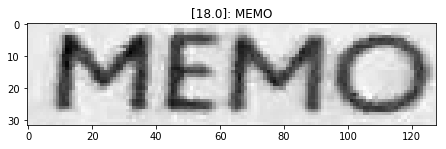

In [13]:
im_cum=0
for idx,orig_crop in enumerate(crops):
    orig_crop=cv2.transpose(cv2.cvtColor(orig_crop, cv2.COLOR_BGR2GRAY))
    end_pos=im_cum+seg_size[idx]
    img_group=image_lst[im_cum:end_pos]
    rec_group=rec_page[im_cum:end_pos]
    text='['+str(idx)+']: '+' '.join(rec_group)
    #print(orig_crop.shape)
    log_image(experiment, cv2.resize(orig_crop, (32,128), interpolation=cv2.INTER_CUBIC), text, '', test_dir, counter=str(idx), epoch=str('A'))
    for idxx, mini_crop in enumerate(img_group):
        text='['+str(idx)+'.'+str(idxx)+']: '+rec_group[idxx]
        log_image(experiment, cv2.resize(mini_crop, (32,128), interpolation=cv2.INTER_CUBIC), text, '', test_dir, counter=str(idx), epoch=str(idxx))
    im_cum=end_pos